In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Reformat portfolio data. For this cell to run correctly, ``ESG Portfolios.xlsx`` must be the unmodified file from bCourses.

In [2]:
portfolios = pd.read_excel('ESG Portfolios.xlsx')
portfolios.columns = portfolios.iloc[0:3].fillna(method='bfill').iloc[0]
portfolios = portfolios.iloc[3:]
portfolios = portfolios[portfolios['UNIT NAME'] != 'Totals']
portfolios.dropna(axis='index', how='all', inplace=True)
portfolios.dropna(axis='columns', how='all', inplace=True)
portfolios['portfolio'] = (portfolios.isna().any(axis='columns') * portfolios['UNIT NAME']).replace('', np.NaN).fillna(method='ffill')
portfolios.dropna(axis='index', how='any', inplace=True)
portfolios.set_index(['Location', 'portfolio', 'UNIT NAME'], inplace=True)
portfolios.sort_index(axis='index',level=['Location', 'portfolio'], inplace=True)

Process demand profile data. As for the portfolios, the filename and contents should be unmodified from bCourses.

In [3]:
profiles = pd.read_excel('ESG Demand Year 2.xlsx', header=2, index_col=[1,0,2])
profiles.dropna(axis='index', how='any', inplace=True)
profiles.sort_index(inplace=True)

As a baseline, assume each generator bids marginal cost. In general, the ``Bid`` column can be chosen to test any bid profile, though the column name must not be changed.

In [4]:
portfolios['Bid'] = portfolios['Total Marginal Cost']

Define a function to perform a dispatch in an isolated market with no transmission

In [5]:
def location_dispatch(market, intercept, slope):
    market.sort_values(by='Bid', inplace=True)
    market['Dispatch'] = np.maximum(
        np.minimum(
            intercept + slope*market.Bid - market.Capacity.cumsum().shift(fill_value=0), 
            market.Capacity
        ), 
        0
    )
    return market

Define a function to dispatch both regions

In [6]:
def codispatch(market, profile):

    # Perform initial dispatch without transmission
    market = market.groupby(level = 'Location', group_keys=False).apply(
        lambda df: location_dispatch(
            df, 
            intercept=profile.loc[df.name,'Load Intercept'],
            slope=profile.loc[df.name,'Load Slope']
        )
    )

    return market

In [7]:
def transmission_capacity(market, line_limit):
    bids = np.minimum((market.Capacity - market.Dispatch).cumsum(), line_limit)
    market.Capacity = bids.diff().fillna(bids)
    market = market[market.Capacity != 0]
    return market

In [8]:
def dispatch(market, profile):

    market = codispatch(market, profile)

    market = market.groupby(level='Location').apply(
        lambda df: pd.concat(
            [
                df,
                transmission_capacity(
                    market.loc[market.index.get_level_values('Location') != df.name],
                    10000
                )
            ]
        )
    )
    market.index.rename('Origin', level=1, inplace=True)
    market = codispatch(market, profile)

    print(profile)
    profile['Load Intercept'] += market.loc[market.index.get_level_values('Location') != market.index.get_level_values('Origin')].Dispatch.groupby('Origin').sum()
    print(profile)

    market = codispatch(market, profile)

    return (market, profile)

Run simulation for hour 1, day 1, both regions. For now, assume there is no transmission capacity.

In [9]:
first_hour = profiles.loc[(['North', 'South'], 1, 1)].droplevel(['Day', 'Hour'])
(portfolios, first_hour) = dispatch(portfolios, first_hour)

          Load Intercept  Load Slope
Location                            
North        3628.112566   -3.359991
South        8126.964877   -3.035355
         Load Intercept  Load Slope
Location                           
North       5535.180938   -3.359991
South       8126.964877   -3.035355


In [10]:
first_hour

,Load Intercept,Load Slope
Location,,
North,5535.180938,-3.359991
South,8126.964877,-3.035355


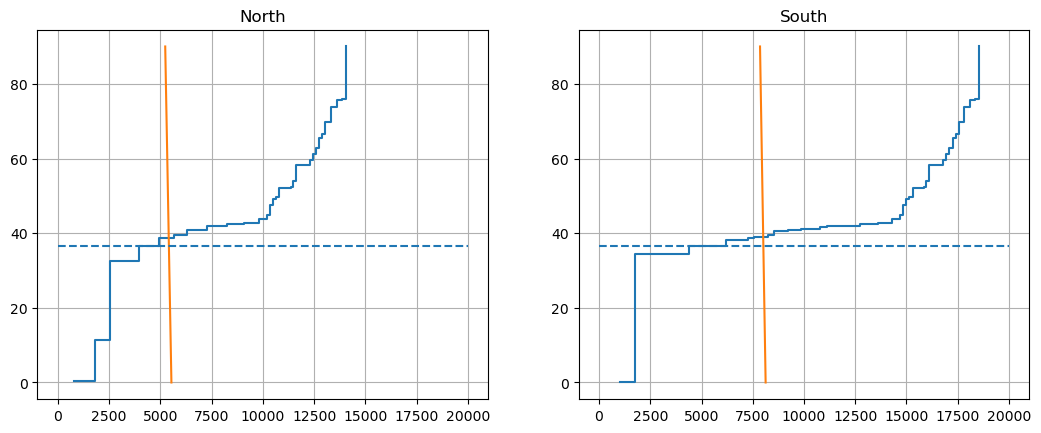

In [27]:
fig, ax = plt.subplots(1,2)
for i, (name, market) in enumerate(portfolios.groupby('Location')):
    intercept = first_hour.loc[name,'Load Intercept']
    slope = first_hour.loc[name,'Load Slope']
    ax[i].step(market.Capacity.cumsum(), market.Bid, where='post')
    ax[i].plot([intercept + slope*market.Bid.max(), intercept], [market.Bid.max(), 0])
    ax[i].grid()
    ax[i].set_title(name)
[a.set_ylim(ax[np.argmax([a.get_ylim()[1] for a in ax])].get_ylim()) for a in ax]
[a.hlines(36.61,0,20000,linestyle='--') for a in ax]
fig.set_size_inches(fig.get_size_inches()*[2,1])
fig.show()